Creating a model to predict iris species from Sepal length/width and Petal length/width


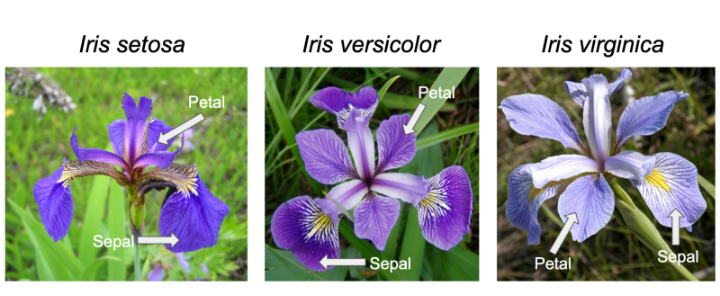

In [ ]:
from IPython.display import Image, display
display(Image(filename="../media/iris.png"))

In [5]:
from datasets import load_dataset

dataset = load_dataset("scikit-learn/iris")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species'],
        num_rows: 150
    })
})


In [6]:
df = dataset['train'].to_pandas()
print(f'species: {df["Species"].unique()}')

df.head()

species: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


# creating a neural network 
4 Inputs -> 16 Hidden Neurons -> 3 Outputs

- 4 Inputs correspond to Sepal Length/Width and Petal Length/Width
- 3 Outputs Map to one of Species ( 'Iris-setosa' 'Iris-versicolor' 'Iris-virginica' )

In [7]:
import torch
import torch.nn as nn

class SimpleMLP(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.net = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )

    def forward(self, x):
        return self.net(x)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Extract features and target
features = df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']].values
labels = df['Species'].values

# Encode labels to integers
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# Split dataset into train and test (let's use 80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(
    features, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

# Convert to torch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [9]:
next(zip(x_train, y_train))

(tensor([4.4000, 2.9000, 1.4000, 0.2000]), tensor(0))

In [10]:
model = SimpleMLP()
logits = model(x_train[0])
f_loss = nn.CrossEntropyLoss()
f_loss(logits, y_train[0])

tensor(1.2124, grad_fn=<NllLossBackward0>)

In [11]:
model = SimpleMLP()
f_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

def accuracy(model, x, y):
    model.eval()
    with torch.no_grad():
        logits = model(x)
        preds = logits.argmax(dim=1)
        return (preds == y).float().mean().item()

losses = []
acc = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()

    # forward ------------>
    logits = model(x_train)        # shape: (N, 3)
    loss = f_loss(logits, y_train) # y shape: (N,)

    # <----------- backward
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        acc.append(accuracy(model, x_test, y_test))
        losses.append(loss.item())


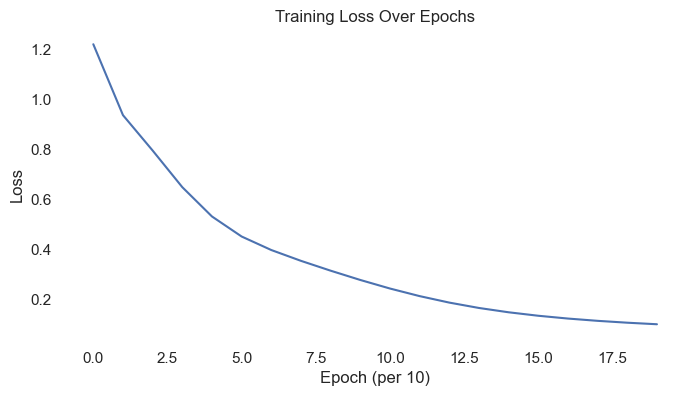

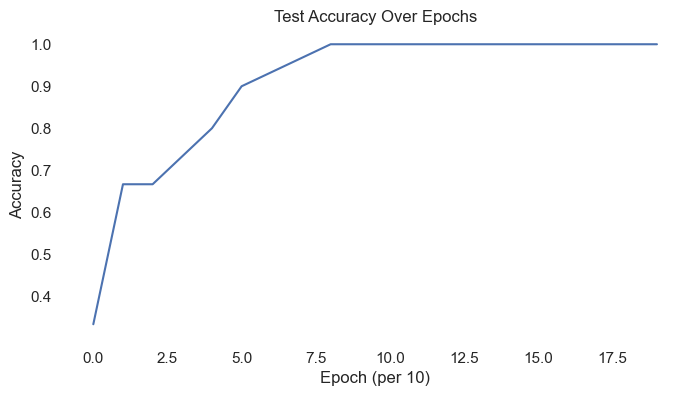

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", rc={"axes.facecolor": (0, 0, 0, 0)})

# Plot Loss
plt.figure(figsize=(8, 4), facecolor="none")  # transparent figure background
sns.lineplot(x=range(len(losses)), y=losses)
plt.xlabel('Epoch (per 10)')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.gcf().patch.set_alpha(0.0)   # transparent figure background
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 4), facecolor="none")  # transparent figure background
sns.lineplot(x=range(len(acc)), y=acc)
plt.xlabel('Epoch (per 10)')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.gcf().patch.set_alpha(0.0)   # transparent figure background
plt.show()